In [196]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [224]:
start = dt.datetime(2017,1,1)
end = dt.date.today()

**Traditional Portfolio with 60 on US equities and World equities and 40 on US long duration government fixed income**

In [875]:
traditional = {
    'EDV':'Vanguards Long Duration Government Bonds',
    'VOO':'Vanguard S&P500 ETF',
    'VXUS':'Vanguard Total World Equities'
}

tickers = sorted(list(traditional.keys()))

In [876]:
#Fetch the data from 1/1/2017 to today.
data = pdr.get_data_yahoo(tickers,start,end)

In [877]:
#Keeping the Adjusted Close price only
data = data['Adj Close']

In [878]:
data.head()

Symbols,EDV,VOO,VXUS
Date,,,
2017-01-03,91.978523,187.425049,39.457485
2017-01-04,92.354042,188.531082,39.892960
2017-01-05,94.673958,188.385986,40.191814
2017-01-06,93.347099,189.120331,40.106419
2017-01-09,94.423615,188.522018,40.029587


In [879]:
#Create a new dataframe with returns by taking the logs with one day lag. 
returns = np.log(data / data.shift())

In [880]:
#Drop the first row of the dataframe
returns = returns.dropna()

[Text(0.5, 1.0, 'Correlation Matrix')]

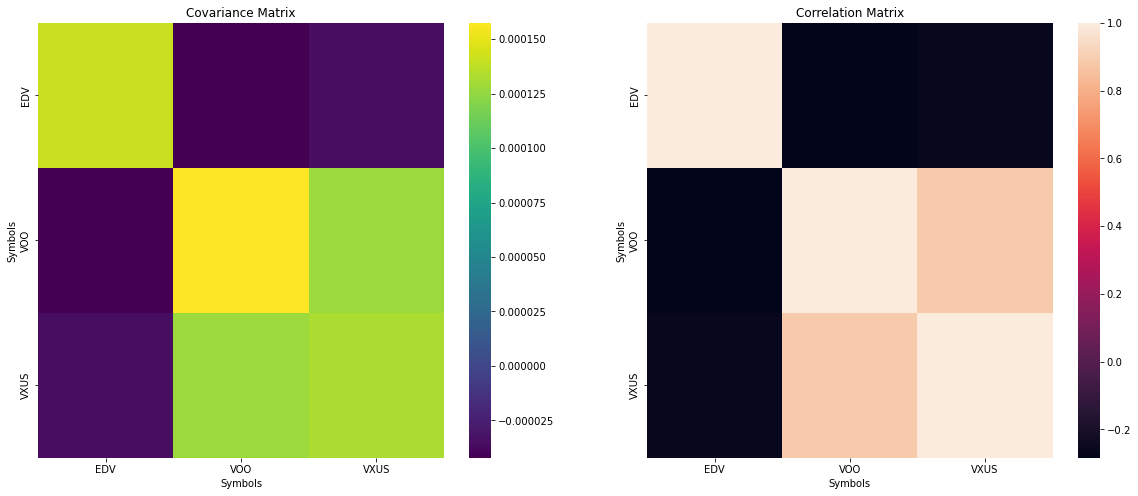

In [890]:
#Visualize the covariance and correlation matrices of the three assets.

fig, ax = plt.subplots(1,2,figsize=(20,8))

sns.heatmap(returns.cov(), cmap='viridis', ax=ax[0]).set(title='Covariance Matrix')
sns.heatmap(returns.corr(), ax=ax[1]).set(title='Correlation Matrix')

**Simulation of 15000 portfolios**

In [882]:
n = 25000
weight = np.zeros((n,len(tickers)))

meanRet = returns.mean()
sigma = returns.cov()


exp_return = np.zeros(n)
exp_volatility = np.zeros(n)
sharpe_ratio = np.zeros(n)


for k in range(n):
    w = np.array(np.random.random(len(tickers)))
    w = w / np.sum(w)
    weight[k, :] = w
    
    
    exp_return[k] = np.sum(meanRet*w)*252
    exp_volatility[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w))*252)
    
    sharpe_ratio[k] = exp_return[k] / exp_volatility[k]



In [883]:
max_index = sharpe_ratio.argmax()

min_vola = exp_volatility.argmin()

print('Weights:',weight[max_index,:],'Sharpe:',sharpe_ratio[max_index],'E[R]:',exp_return[max_index])

Weights: [0.28822665 0.7110035  0.00076985] Sharpe: 0.6406294128376344 E[R]: 0.08753012435497597


**Minimization of volatility in order to draw the efficient frontier**

In [884]:
plot_returns = np.linspace(exp_return[min_vola],0.12,100)
volatility_opt = []

def minimizeVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))*np.sqrt(252)
    return V

#Constraint so the sum of weights in our portfolio equal 1.
def sumToOne(w):
    return np.sum(w)-1

def getReturn(w):
    w = np.array(w)
    R = np.sum(meanRet*w)*252
    
    return R

#Starting guess weights for the portfolio.
w_0 = [0.25,0.25,0.5]

#The intervals that the weights can lie.
bounds = tuple((0,1) for element in tickers)

plot_constraints = ({'type':'eq','fun':sumToOne},
                   {'type':'eq','fun':lambda w: getReturn(w) - r})

for r in plot_returns:
    opt = minimize(minimizeVolatility,w_0,method='SLSQP',bounds=bounds,constraints=plot_constraints)
    volatility_opt.append(opt['fun'])

**Plot the frontier**

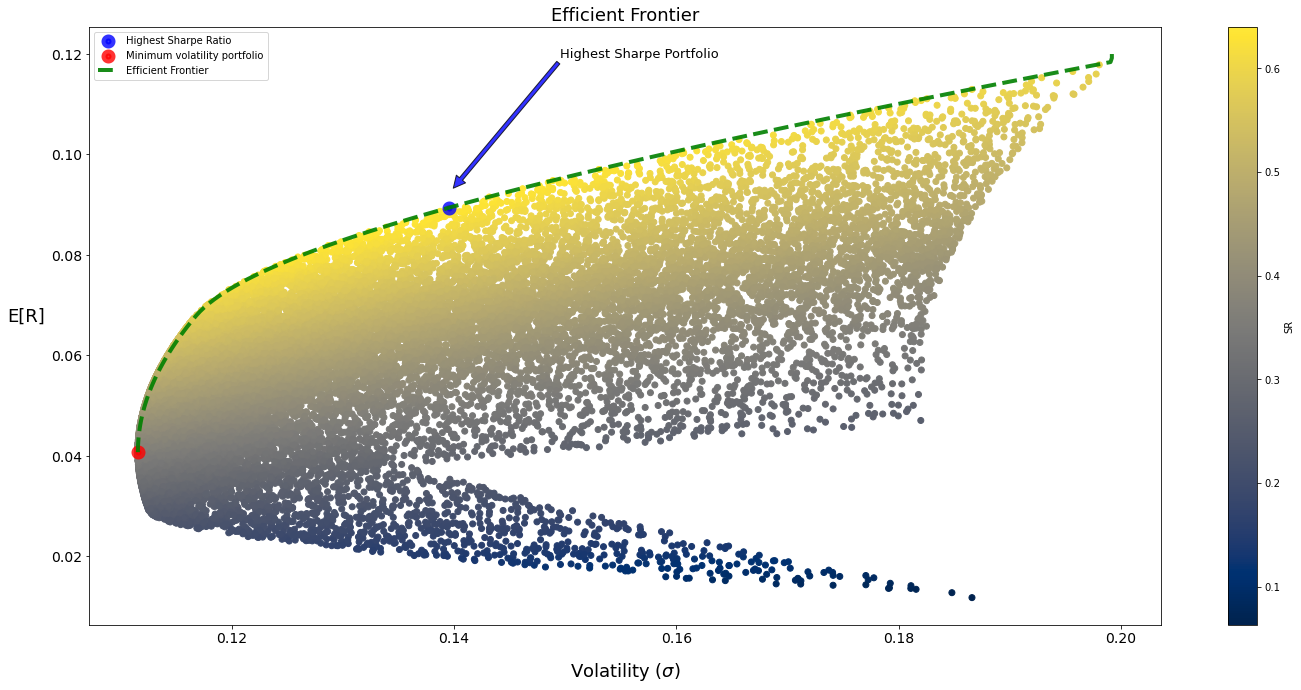

In [873]:
plt.figure(figsize=(24,11))

#Plotting all the possible combinations
plt.scatter(exp_volatility,exp_return,c=sharpe_ratio,cmap='cividis',linewidth=1)
plt.colorbar(label='SR')
plt.title('Efficient Frontier',fontsize=18)
plt.xlabel('Volatility (${\sigma}$)',fontsize=18,labelpad=15)
plt.ylabel('E[R]',fontsize=18,rotation=0,labelpad=25)
plt.tick_params(axis='both',labelsize=14)

#Plotting the highest sharpe ratio portfolio. 
plt.scatter(exp_volatility[max_index],exp_return[max_index],linewidth=8,color='blue',alpha=0.8,label='Highest Sharpe Ratio')
plt.annotate('Highest Sharpe Portfolio',xy=(exp_volatility[max_index]+0.0004,exp_return[max_index]+0.004),xytext=(exp_volatility[max_index]+0.01,exp_return[max_index]+0.03),fontsize=13,arrowprops=dict(facecolor='blue', alpha=0.80))

#Plotting the minimum variance portfolio
plt.scatter(exp_volatility[min_vola],exp_return[min_vola],linewidth=8,color='red',alpha=0.8,label='Minimum volatility portfolio')

plt.plot(volatility_opt,plot_returns,linestyle='--',label='Efficient Frontier',linewidth='4',alpha=0.9,color='green')

plt.legend()
plt.show()

**Optimization with scipy. We maximize the Sharpe ratio by minimizing its negative values.**

We therefore want to solve the following problem. $$\min \Big[-\Big(\frac{\boldsymbol{\mu}^T\boldsymbol{w}-r_{f}}{\sqrt{\boldsymbol{w}^T\boldsymbol{\Sigma w}}}\Big)\Big]$$ $$s.t$$   $$\boldsymbol{w}\geq0$$ $$\boldsymbol{1}^T\boldsymbol{w}=1$$ where $\boldsymbol{\mu}$ is a $\boldsymbol{n}\times 1$ vector of mean returns, $\boldsymbol{w}$ is a $\boldsymbol{n}\times 1$ vector of the assets' weights and $\boldsymbol{\Sigma}$ is the $\boldsymbol{n}\times\boldsymbol{n}$ covariance matrix.


In [731]:
from scipy.optimize import minimize

In [755]:
#Create a function that returns the negative Sharpe Ratio
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanRet*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = R / V
    return -1* SR

#Constraint so the sum of weights in our portfolio equals 1.
def sumToOne(w):
    return np.sum(w)-1

#Starting point for the optimization a random 25/25/50 portfolio.
w_0 = [0.25,0.25,0.5]

#The intervals that the weights can lie. (0,1)
bounds = tuple((0,1) for element in tickers)


constraints=({'type':'eq','fun':sumToOne})
weight_opt = minimize(negativeSR, w_0,method='SLSQP',bounds=bounds,constraints=constraints)



**Rounded weights on each asset that produces the highest Sharpe Ratio**

In [757]:
print('weights: ',weight_opt.x)

weights:  [0.28371947 0.71628053 0.        ]


## Optimized Portfolio with Alternative Assets

In this simulation i include 'AB Select US Long/Short Portfolio(ASLAX)' a fund with Long/Short strategy and 'IQ Hedge Multi-Strategy Tracker(QAI)' an ETF which tracks the IQ Hedge Multi-Strategy Index. 

In [835]:
optimized = {
    'EDV':'Vanguard Long Duration Government Bonds',
    'VOO':'Vanguard S&P500 ETF',
    'VXUS':'Vanguard Total World Equities',
    'QAI':'Alternative Fund Invesco',
    'ASLAX':'Long/Short Equities'
    
}

optimized_tickers = sorted(list(optimized.keys()))

In [836]:
optimized_data = pdr.get_data_yahoo(optimized_tickers,start,end)

In [837]:
optimized_data = optimized_data['Adj Close']

In [838]:
optimized_data.head()

Symbols,ASLAX,EDV,QAI,VOO,VXUS
Date,,,,,
2017-01-03,8.524883,91.978539,27.004423,187.425079,39.457481
2017-01-04,8.539259,92.354042,27.089165,188.531082,39.892956
2017-01-05,8.532071,94.673943,27.126827,188.386047,40.191811
2017-01-06,8.546447,93.347099,27.089165,189.120331,40.106426
2017-01-09,8.532071,94.423592,27.126827,188.521988,40.029587


In [839]:
optimized_returns = np.log(optimized_data / optimized_data.shift())

In [840]:
optimized_returns.dropna(inplace=True)

[Text(0.5, 1.0, 'Correlation Matrix')]

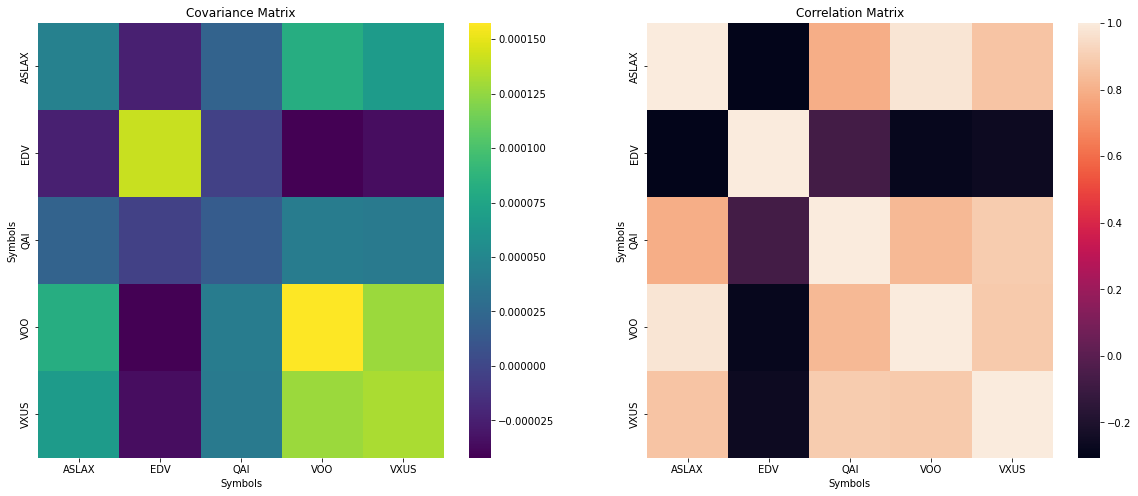

In [887]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

sns.heatmap(optimized_returns.cov(), cmap='viridis', ax=ax[0]).set(title='Covariance Matrix')
sns.heatmap(optimized_returns.corr(), ax=ax[1]).set(title='Correlation Matrix')

**Simulation of 15000 portfolios**

In [866]:
n = 25000
weight_o = np.zeros((n,len(optimized_tickers)))

meanRet_o = optimized_returns.mean()
sigma_o = optimized_returns.cov()


exp_return_o = np.zeros(n)
exp_volatility_o = np.zeros(n)
sharpe_ratio_o = np.zeros(n)


for k in range(n):
    w_o = np.array(np.random.random(len(optimized)))
    w_o = w_o / np.sum(w_o)
    weight_o[k, :] = w_o
    
    
    exp_return_o[k] = np.sum(meanRet_o*w_o)*252
    exp_volatility_o[k] = np.sqrt(np.dot(w_o.T,np.dot(sigma_o,w_o))*252)
    
    sharpe_ratio_o[k] = exp_return_o[k] / exp_volatility_o[k]
    
    
    

In [867]:
max_index_o = sharpe_ratio_o.argmax()
min_index_o = exp_volatility_o.argmin()
print('Sharpe ratio:',sharpe_ratio_o[max_index_o])

Sharpe ratio: 0.7243613122039951


In [868]:
weight_o[max_index_o], exp_return_o[max_index_o]

(array([0.73444696, 0.17766418, 0.01425551, 0.04963363, 0.02399972]),
 0.06403363629943416)

**Minimize the volatility in the expected return interval $[0.04,0.12]$ in order to draw the efficient frontier**

In [869]:
xreturns_o = np.linspace(exp_return_o[min_index_o],0.12,50)
opt_volatility_o = []



def minimizeVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma_o,w))*252)
    return V


def getReturnO(w):
    w = np.array(w)
    R_o = np.sum(meanRet_o*w)*252
    
    return R_o

#Sum of weights to equal 1
def checkToSumO(w):
    return np.sum(w)-1

w0_o = [0.20,0.20,0.20,0.20,0.20]

#Intervals of weights
bounds = tuple((0,1) for ticker in optimized_tickers)

constraints_o = ({'type':'eq', 'fun':checkToSumO}, {'type':'eq','fun':lambda w: getReturnO(w) - r})

for r in xreturns_o:
    opt = minimize(minimizeVolatility,w0_o,method='SLSQP',bounds=bounds, constraints=constraints_o)
    
    opt_volatility_o.append(opt['fun'])

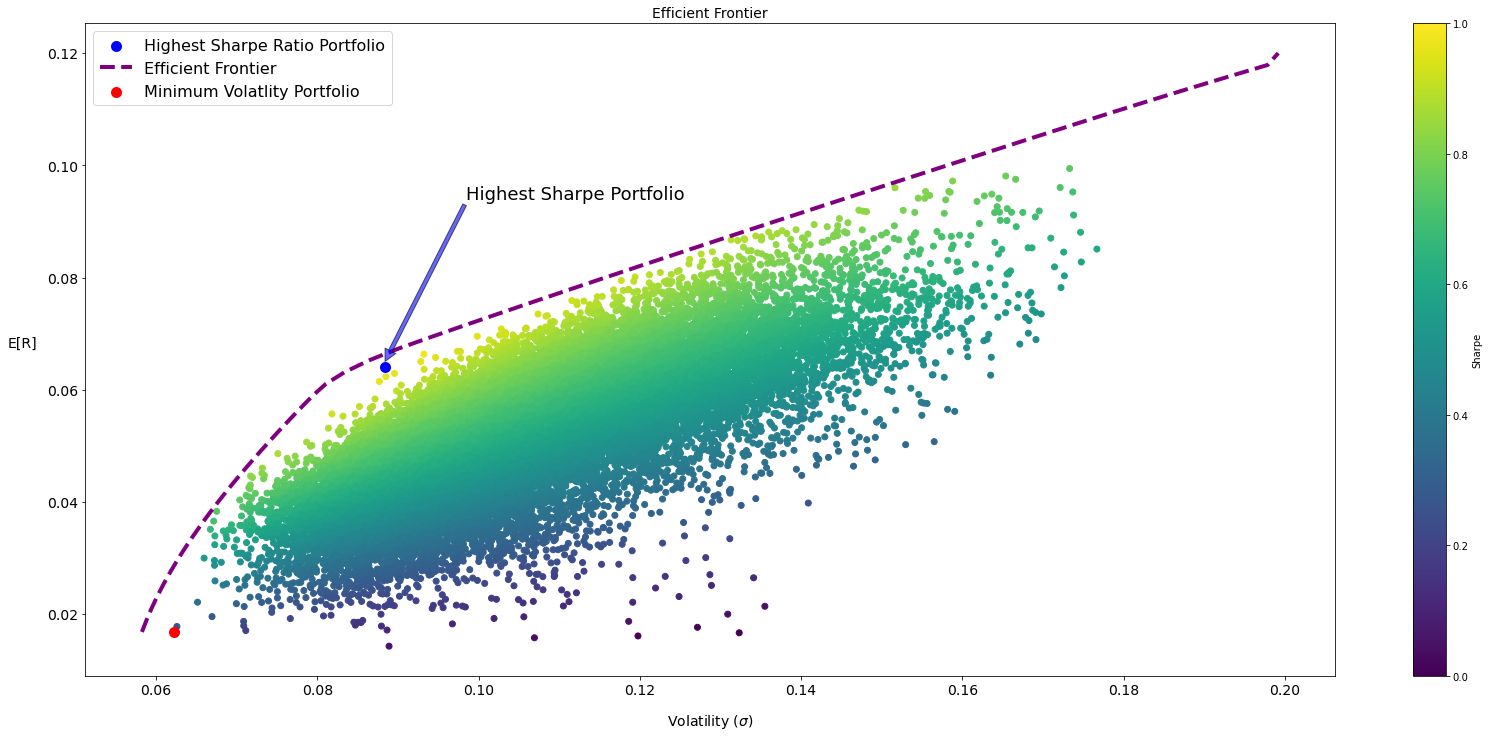

In [872]:
plt.figure(figsize=(28,12))


plt.scatter(exp_volatility_o,exp_return_o,c=sharpe_ratio_o,cmap='viridis')
plt.scatter(exp_volatility_o[max_index_o],exp_return_o[max_index_o],c='blue',linewidth=5,label='Highest Sharpe Ratio Portfolio')
plt.plot(opt_volatility_o,xreturns_o,linestyle='--',linewidth=4,color='purple',label='Efficient Frontier')
plt.scatter(exp_volatility_o[min_index_o],exp_return_o[min_index_o],c='red',linewidth=5, label='Minimum Volatlity Portfolio')
plt.colorbar(label='Sharpe')
plt.title('Efficient Frontier',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.annotate('Highest Sharpe Portfolio',xy=(exp_volatility_o[max_index_o],exp_return_o[max_index_o]+0.001),xytext=(exp_volatility_o[max_index_o]+0.01,exp_return_o[max_index_o]+0.03),fontsize=18,arrowprops=dict(facecolor='blue', alpha=0.60))
plt.xlabel('Volatility (${\sigma}$)',fontsize=14,labelpad=15)
plt.ylabel('E[R]',fontsize=14,rotation=0,labelpad=25)
plt.legend(fontsize=16)
plt.show()

In [859]:
import pandas as pd

In [863]:
results = {'Traditional Portfolio 60/40':[round(sharpe_ratio[max_index],2),round(exp_return[max_index]*100,1)],
           'Optimized with Alternative Investments ETF':[round(sharpe_ratio_o[max_index_o],2),round(exp_return_o[max_index_o]*100,1)]}

In [864]:
results_df = pd.DataFrame(results,index=['Sharpe Ratio','E(R)'])

In [865]:
results_df

,Traditional Portfolio 60/40,Optimized with Alternative Investments ETF
Sharpe Ratio,0.64,0.73
E(R),8.90,5.80
